# A quick overview of some of DESDEO's main capabilities

**Note:** This notebook contains the code shown in the four use cases considered in the article titled _DESDEO: an open framework for interactive multiobjective optimization_. Cells containing code found in the article will be marked accordingly (by a comment on the first line). The code shown may vary from the one in the article due to new additions and/or changes in the DESDEO framework. This is to ensure that the code shown can be run and experimented with in the future as well.

This overview should give the novice user interested in DESDEO a brief overview of how the framework may be utilized. We will consider a multiobjective optimization problem with five objectives and two variables. The problem will be treated as an analytical problem, a data-driven problem, and a computationally expensive problem. We will show how the problem can be solved utilizing MCDM and EMO methods both separately and in tandem (hybridizing them). **Note:** Link to article with additional information to be added later.

## The probelm

The considered problem - the river pollution problem - in the use cases is presented [here](https://ieeexplore.ieee.org/document/35354). Its analytical definiton can be stated as:

\begin{equation}
\begin{array}{rll}
\text{min}  & f_1({\mathbf{x}}) =& - 4.07 - 2.27 x_1 \\ 
\text{min}  & f_2({\mathbf{x}}) =& - 2.60 - 0.03 x_1  - 0.02 x_2 \\
&&\quad - \frac{0.01}{1.39 - x_1^2} - \frac{0.30}{1.39 - x_2^2} \\ 
\text{min}  & f_3({\mathbf{x}}) =& - 8.21 + \frac{0.71}{1.09 - x_1^2} \\ 
\text{min}  & f_4({\mathbf{x}}) =& - 0.96 + \frac{0.96}{1.09 - x_2^2} \\ 
\text{min}  & f_5({\mathbf{x}}) =& \max\{|x_1 - 0.65|, |x_2 - 0.65|\} \\ 
&&\\
\text{s.t.}  && 0.3 \leq x_1, x_2 \leq 1.0, \\
\end{array}
\end{equation}

where each objective is to be minimized subject to box-constraints imposed on the variables.

## Use case 1: solving problems with analytical formulations

If we wish to solve a problem with an analytical formulation, such as the river pollution problem, we can proceed as follows. First, we will define the problem in DESDEO. We import some required modules from _desdeo-problem_ for this purpose. _desdeo-problem_ contains modules that are used to define multiobjective optimization problems. We import the following modules:

In [1]:
# Source code 1
import numpy as np

from desdeo_problem.problem import MOProblem
from desdeo_problem.problem import Variable
from desdeo_problem.problem import ScalarObjective

Next ,we define the objective functions of the river pollution problem first as Python functions and then wrap them inside instances of the `ScalarObjective` class. The _scalar_ in the name implies that the objective is itself a scalar-valued function (i.e., $\mathbb{R}^n \to \mathbb{R}$ for some positive $n$). The resulting objects are then stored in a list. In code: 

In [2]:
# Source code 2
def f_1(x: np.ndarray) -> np.ndarray:
    x = np.atleast_2d(x)  # This step is to guarantee that the function works when called with a single decision variable vector as well.
    return -4.07 - 2.27*x[:, 0]

def f_2(x: np.ndarray) -> np.ndarray:
    x = np.atleast_2d(x)
    return -2.60 - 0.03*x[:, 0] - 0.02*x[:, 1] - 0.01 / (1.39 - x[:, 0]**2) - 0.30 / (1.39 + x[:, 1]**2)

def f_3(x: np.ndarray) -> np.ndarray:
    x = np.atleast_2d(x)
    return -8.21 + 0.71 / (1.09 - x[:, 0]**2)

def f_4(x: np.ndarray) -> np.ndarray:
    x = np.atleast_2d(x)
    return -0.96 - 0.96 / (1.09 - x[:, 1]**2)

def f_5(x: np.ndarray) -> np.ndarray:
    return np.max([np.abs(x[:, 0] - 0.65), np.abs(x[:, 1] - 0.65)], axis=0)

objective_1 = ScalarObjective(name="f_1", evaluator=f_1)
objective_2 = ScalarObjective(name="f_2", evaluator=f_2)
objective_3 = ScalarObjective(name="f_3", evaluator=f_3)
objective_4 = ScalarObjective(name="f_4", evaluator=f_4)
objective_5 = ScalarObjective(name="f_5", evaluator=f_5)

objectives = [objective_1, objective_2, objective_3, objective_4, objective_5]

When defining objectives, it is expected that they may be called with either a single set of decision variables or a set of such sets. I.e.,:

In [3]:
# single set of decision variables
x_single = np.array([0.8, 0.5])

# set of sets
x_multi = np.array([[0.8, 0.5], [0.31, 0.88], [0.34, 0.33]])

# Both sets work when evaluated with the defined objective functions.
# Notice how we get one value for each provided set of decision variables.
print(f"f_1({x_single}) = ", f_1(x_single))
print(f"f_1({x_multi}) = ", f_1(x_multi))

f_1([0.8 0.5]) =  [-5.886]
f_1([[0.8  0.5 ]
 [0.31 0.88]
 [0.34 0.33]]) =  [-5.886  -4.7737 -4.8418]


The variables of the problem are defined in a very similar fashion compared to the objectives:

In [4]:
# Source code 3
x_1 = Variable("x_1", 0.5, 0.3, 1.0)
x_2 = Variable("x_2", 0.5, 0.3, 1.0)

variables = [x_1, x_2]

Notice the arguments given to the initializer of 'Variable': the last and second-to-last define the variabels upper and lower bounds, respectively, while the second argument defines a variable's initial value and current value, which is sometimes useful information. The upper and lower bounds are optional; if not provided, appropiate infinims will be assumed for the bounds. The documentation should confirm these claims regarding the arguments:

In [5]:
help(Variable)

Help on class Variable in module desdeo_problem.problem.Variable:

class Variable(builtins.object)
 |  Variable(name: str, initial_value: float, lower_bound: float = -inf, upper_bound: float = inf) -> None
 |  
 |  Simple variable with a name, initial value and bounds.
 |  
 |  Args:
 |      name (str): Name of the variable
 |      initial_value (float): The initial value of the variable.
 |      lower_bound (float, optional): Lower bound of the variable. Defaults
 |          to negative infinity.
 |      upper_bound (float, optional): Upper bound of the variable. Defaults
 |          to positive infinity.
 |  
 |  Attributes:
 |      name (str): Name of the variable.
 |      initial_value (float): Initial value of the variable.
 |      lower_bound (float): Lower bound of the variable.
 |      upper_bound (float): Upper bound of the variable.
 |      current_value (float): The current value the variable holds.
 |  
 |  Raises:
 |      VariableError: Bounds are incorrect.
 |  
 |  Metho

Most of the classes, their methods, and functions should be equipped with docstrings so that the `help` utility should give some insight on how to use them.

We are now ready to define the multiobjective optimization problem itself. Most of the work has already been done in defining the objectives and variables:

In [6]:
# Source code 4
mo_problem = MOProblem(variables=variables, objectives=objectives)

At this point, we could start solving the problem with various methods found in DESDEO or we can use the problem in various other ways as well to gain additional insight. Since we will be using Synchronous NIMBUS to solve the problem in this use case, we need knowledge of the upper and lower bounds of the possible objective values contained in the set of feasible solutions. For this, we can compute the ideal and nadir points of the problem. The simplest way to compute the ideal and approximate the nadir is to use a pay-off table. A method based on the pay-off table to compute the ideal and (approximation of) the nadir point is found in the _utilities_ module of the _desdeo-mcdm_ package. The ideal and nadir points are then stored as attributes of the `mo_problem` object to readily access them later on. We proceed as follows:

In [7]:
# Source code 5
from desdeo_mcdm.utilities import payoff_table_method

ideal, nadir = payoff_table_method(mo_problem)

mo_problem.ideal = ideal
mo_problem.nadir = nadir

The ideal and nadir points should give us an idea of the ranges of the objectives. Indeed, this is the case:

In [8]:
print(f"Ideal point: {mo_problem.ideal}")
print(f"Nadir point: {mo_problem.nadir}")
print(f"Ideal strictly better than nadir?: {np.all(mo_problem.ideal <= mo_problem.nadir)}")

Ideal point: [ -6.33999773  -2.8643435   -7.49999957 -11.6263998    0.        ]
Nadir point: [-4.75100227 -2.7632841  -0.32128642 -1.92000058  0.349999  ]
Ideal strictly better than nadir?: True


We can now actually begin solving the river pollution problem using the Synchronous NIMBUS method. As we have already defined an instance of `MOProblem`, initializing and starting the method is straight forward:

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Source code 6
from desdeo_mcdm.interactive.NIMBUS import NIMBUS

nimbus = NIMBUS(mo_problem)

classification_request, _ = nimbus.start()

The `start` method returns two _requests_ of which the first one is of interest here. Its `contents` attribute is a `dict` the keys of which we can inspect:

In [10]:
classification_request.content.keys()

dict_keys(['message', 'objective_values', 'classifications', 'levels', 'number_of_solutions'])

In the `content` of each _request_, at least the `message` entry exists. This entry contains information on how to proceed:

In [11]:
print(classification_request.content["message"])

Please classify each of the objective values in one of the following categories:
	1. values should improve '<'
	2. values should improve until some desired aspiration level is reached '<='
	3. values with an acceptable level '='
	4. values which may be impaired until some upper bound is reached '>='
	5. values which are free to change '0'
Provide the aspiration levels and upper bounds as a vector. For categories 1, 3, and 5,the value in the vector at the objective's position is ignored. Supply also the number of maximumsolutions to be generated.


We can interact with the method by defining the _response_, an attribute of the _request_, following the instructions contained in the `message` printed above. To help us in this task, we can first inspect the current objective values as:

In [12]:
classification_request.content["objective_values"]

array([-6.06531998, -2.79638253, -5.97284071, -4.5267143 ,  0.25600481])

We may then define our _response_ with the required classifications to continute iterating the method:

In [13]:
# Source code 7
response = {
    "classifications": ["<=", "0", "=", ">=", "<"],
    "levels": [-6.2, 0, 0, -3.0, 0],
    "number_of_solutions": 2,
}

classification_request.response = response

save_request, _ = nimbus.iterate(classification_request)

/home/kilo/.cache/pypoetry/virtualenvs/desdeo-5gtrLBsD-py3.9/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


We got a new request (`save_request`) which contains newly computed solutions based on the classifications given. These new solutions are:

In [14]:
save_request.content["objectives"]

[array([-6.06531997, -2.79891851, -5.97284076, -3.97568914,  0.22899558]),
 array([-5.54551059e+00, -2.80835300e+00, -7.14631992e+00, -2.39821262e+00,
         4.66671912e-06])]

This request is similar to the earlier one: its `content` attribute will contain at least a `message` entry with instructions on what needs to be defined in the `response` attribute of `save_request`. In Synchronous NIMBUS, the next step would be to indicate whether we would like some of the computed solutions to be saved into an archive for later viewing. Further steps would consist of computing intermediate solutions, providing new classifications, and choosing a new preferred solution. However, we will conclude this use case here. Further information on the implementation of Synchronous NIMBUS in DESDEO can be found [in the documentation of _desde-mcdm_](https://desdeo-mcdm.readthedocs.io/en/latest/notebooks/synchronous_nimbus.html).

## Use case 2: data-driven problem

Here we demonstrate how a data-driven multiobjective optimization problem may be solved using DESDEO and an evolutionary method found in _desdeo-emo_.

We will assume that the river pollution problem has no known explicit form. Instead, the have only data on the probem in the form of variable and objective vector pairs. To emulate a data-driven problem, we have pre-computed a small number (100) of solutions consisting of decision variable and objective values. We can then use these points to train a surrogate model which is computationally less expensive to evaluate and can therefore be readily used in an interactive method. We assume to have already computed the points mentioned earlier and that they are stored in a file `River_Pollution.csv` in a CSV format. The first two columns will consist of the decision variable values and the last five columns will consists of the objective values. We can use this data and together with _desdeo-problem_ and pandas to formulate a data-driven problem in DESDEO:

In [15]:
# Source code 8
import pandas as pd
from desdeo_problem.problem import DataProblem


training_data = pd.read_csv("./data/River_pollution.csv", comment="#")

problem = DataProblem(
    data=training_data, 
    variable_names=["x_0", "x_1"],
    objective_names=["f_1", "f_2", "f_3", "f_4", "f_5"],
    bounds=pd.DataFrame(
        [[0.3, 0.3], [1.0, 1.0]],
        columns=["x_0", "x_1"],
        index=["lower_bound", "upper_bound"]),
)

Next, we can train a surrogate to model each of the objectives. It is possible, and sometimes very desiderable, to use different surrogates for different objectives, but in this example we opt to use the same type of surrogate for each objective. We choose to use Gaussian regression:

In [16]:
# Source code 9
from desdeo_problem.surrogatemodels.SurrogateModels import GaussianProcessRegressor

problem.train(
    models=GaussianProcessRegressor,
    model_parameters={"optimizer":"fmin_l_bfgs_b"}
)

The `GaussianProcessRegressor` we chose to use is a wrapper for the Gaussian process found in scikit-learn. Information about the hyperparameters given to the `optimizer` in Source code 9 can be found in scikit-learn's documentation. However, different surrogate models are also available and readily implemented, if absent.

To solve the problem being modeled by the surrogates, we choose and evolutionary method this time, namely the interactive variant of RVEA implemented in the _desdeo-emo_ package. We will be supplying reference points (three other types of preference may also be supplied; more information can be found in the documentation of _desdeo-emo_). Since RVEA comes in a non-interactive version as well, we will have to specify explicitly to be interested in the interactive version using the `interact` flag. Also, we will have to specify that we will be using a problem based on surragates in a similar fashion:

In [17]:
warnings.filterwarnings("ignore", category=UserWarning)
# Source code 10
from desdeo_emo.EAs import RVEA

evolver = RVEA(
    problem,
    interact=True,
    use_surrogates=True
)

(_, _, refp_request, _), _ = evolver.requests()

refp_request.response = pd.DataFrame([[-5.7, -2.8, -6.9, -3.0, 0.1]],
                                   columns=["f_1", "f_2", "f_3", "f_4", "f_5"]
                                  )

(_, _, refp_request, _), _ = evolver.iterate(refp_request)

We have now computed new solutions according to our given preferences. Let us inspect them together with the reference point using a plot:

<AxesSubplot:>

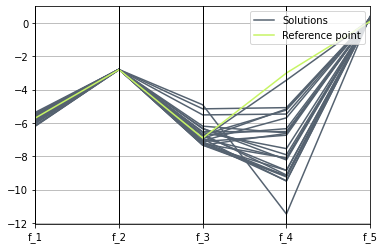

In [18]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

objectives_df = pd.DataFrame(data=evolver.population.objectives)
objectives_df.columns = ["f_1", "f_2", "f_3", "f_4", "f_5"]
objectives_df.insert(0, "type", "Solutions")
objectives_df = objectives_df.append(
    {"type": "Reference point", "f_1": -5.7, "f_2": -2.8, "f_3": -6.9, "f_4": -3.0, "f_5": 0.1}, ignore_index=True)

parallel_coordinates(objectives_df, class_column="type", color=["#556270", "#C7F464"])

As seen from the plot above, quite many of the solutions roughly follow the given reference point. If none of the solutions found is attractive, we could supply new preferences to RVEA or we could otherwise tweak its parameters. However, what we have seen so far should give the rough idea how a data-driven problem can be modeled and solved using an evolutionary method in DESDEO. Next, we will consider the case of solving a computationally expensive multiobjective optimization problem.

## Use case 3: computationally expensive problem

In the case of computationally expensive problems, we may encounter unacceptably long waiting times when solving the problems interactively. This is obviously not desired. In such cases, one solution is to compute a representation of the Pareto optimal front _a priori_ and then use the front in an interactive method to explore the available solutions. In this way, we can avoid long waiting times during the interactive solution process.

Suppose then that the river pollution problem defined at the beginning of this notebook was very expensive. To generate an approximate representaton of the Pareto optimal front, we use the implementation of NSGAIII found in _desdeo-tools_. We use NSGAIII's non-interactive variant to evolve the population for 1000 generations (default) and then extract the non-dominated set of solutions from the final population by invoking the `end` method. This non-dominated set will then work as our representation of the Pareto front (as is often done). In code:

In [19]:
# Source code 11
from desdeo_emo.EAs import NSGAIII

evolver = NSGAIII(mo_problem, interact=False)

while evolver.continue_evolution():
    evolver.iterate()

individuals, pareto_front = evolver.end()

/home/kilo/.cache/pypoetry/virtualenvs/desdeo-5gtrLBsD-py3.9/lib/python3.9/site-packages/desdeo_emo/selection/NSGAIII_select.py:166: RuntimeWarning:

divide by zero encountered in true_divide



We then use the E-NAUTILUS method found in _desdeo-mcdm_. E-NAUTILUS is a good choice of interactive method when we have already computed a representation of the Pareto front. Moreover, E-NAUTILUS is a tradeoff free method, which means that during the interactive process, we will be able to always improve our solution. This is because E-NAUTILUS starts from a bad solution (often the nadir) from which the Pareto front is then gradually approched by taking steps towards it in each iteration according to expressed preferences. We can import E-NAUTILUS and instantiate it as:

In [20]:
# Source code 12
from desdeo_mcdm.interactive import ENautilus

# 'pareto_front' stores the set of solutions computed using NSGA-III
method = ENautilus(pareto_front, ideal, nadir)

enautilus_request = method.start()

As seen, we have used the previously computed representation of the Pareto front, ideal point, and nadir point. Before we can start iterating the method, we will have to specify the number of intermediate solutions we wish to see in each iteration and the number of iterations to iterate the method for:

In [21]:
print(enautilus_request.content["message"])

Please specify the number of iterations as 'n_iterations' to be carried out, and how many intermediate points to show as 'n_points'.


In [22]:
# Source code 13
response = {"n_iterations": 5, "n_points": 3}

enautilus_request.response = response

enautilus_request = method.iterate(enautilus_request)

In the new request, we have now intermediate points and the bounds of the currently reachable solution on Pareto front. We can inspect them:

In [23]:
print("Intermediate points:\n", enautilus_request.content["points"])
print("Upper bounds:\n", enautilus_request.content["upper_bounds"])
print("Lower bounds:\n", enautilus_request.content["lower_bounds"])

Intermediate points:
 [[-4.99964227 -2.7713281  -1.51675587 -2.16439903  0.31953244]
 [-5.01439308 -2.76843095 -1.44869828 -3.48054163  0.34803403]
 [-5.06710072 -2.7738415  -0.4423165  -2.20424663  0.34924982]]
Upper bounds:
 [[-4.98058006 -2.77112614 -3.83081652 -1.97489208  0.35      ]
 [-4.98058006 -2.77112614 -2.00680105 -1.9222225   0.35      ]
 [-4.98058006 -2.77174342 -0.53737674 -1.9222225   0.35      ]]
Lower bounds:
 [[ -6.2565996   -2.82806973  -7.43338816  -7.33345755   0.03116825]
 [ -6.31206939  -2.80272184  -7.43338816 -11.07376461   0.19589683]
 [ -6.3371189   -2.82806973  -7.2701393  -11.33612684   0.03116825]]


From the intermediate points and bounds shown, we can then choose our most preferred one to continue iterating. We can do this by expressing the index (starting from zero) of the point we most prefer. Choosing the last intermediate point looks like this:

In [24]:
# Source code 14
response = {"preferred_point_index": 2}

enautilus_request.response = response

enautilus_request = method.iterate(enautilus_request)

Next, we would have to choose a new preferred solution from the newly computed intermediate points. We would continue until we reach the desired number of iterations and end up with a solution on the representation of the Pareto front given when instantiating `ENautilus`. Since the solution found would still be picked from a set of (approximate) representations of Pareto optimal solutions, we could still improve the solution using the (expensive) original problem and a achievement scalarizing functions, for example.

The point of this use case was, however, to show how to handle a computationally expensive problem, which we have now demonstrated. Moreover, we have also shown how an evolutionary method (NSGA-III) has been hybridized with an MCDM method (E-NAUTILUS). This was a remarkably simple example, but more advanced applications are also possible.

## Use case 4: switching methods

DESDEO allows to seamlessly switch between methods as long as the problem is compatible across the methods. Suppose, for example, that we had now finished iterating the E-NAUTILUS method discussed in the previous subsection. We got the final solution
`[-6.27116931, -2.80042652, -3.46795271, -6.57327201,  0.31967811]`. Since this solution is computed using a set of non-dominated solutions, which represent the Pareto optimal solution, we can improve the solution using the analytical form of the River problem in a method able to handle this kind of problems. We can use Synchronous NIMBUS and initialize it with the solution we ended up in E-NAUTILUS as:

In [25]:
# Source code 15
nimbus_method = NIMBUS(mo_problem, starting_point=np.array([-6.27116931, -2.80042652, -3.46795271, -6.57327201, 0.31967811]))
classification_request, _ = nimbus_method.start()

solution = classification_request.content["objective_values"]

print(f"Improved starting point: {solution}")

Improved starting point: [-6.27116929 -2.80042652 -3.46795321 -6.5732719   0.3196781 ]


We can see that the solution we got in the classification step in NIMBUS is slightly better than the starting point. This is expected. We can continue using NIMBUS as we did in Use case 1. Suppose we would make the following classifications:

In [26]:
# Source code 16
response = {
    "classifications": [">=", ">=", "=", "<=", "<="],
    "levels": [-6.0, -2.81, 0, -5.5, 0.28],
    "number_of_solutions": 4,
}

classification_request.response = response

save_request, _ = nimbus_method.iterate(classification_request)

print(f"New solutions based on the classification:\n{np.array(save_request.content['objectives'])}")

New solutions based on the classification:
[[-6.27116929 -2.80042545 -3.46795321 -6.57403796  0.3196781 ]
 [-6.25694385 -2.80351526 -3.82291043 -4.76892902  0.31341139]
 [-6.23956126 -2.8025631  -4.18812465 -4.78570078  0.30575386]
 [-6.21076915 -2.80107536 -4.67094925 -4.8160743   0.29307011]]


At this point, we may feel like we do not like the way preferences are given in Synchronous NIMBUS. We would like to give an explicit reference point. The environment DESDEO offers allows to readily switch between methods. We can switch to the Reference point method as:

In [27]:
# Source code 17
from desdeo_mcdm.interactive import ReferencePointMethod

rp_method = ReferencePointMethod(mo_problem, mo_problem.ideal, mo_problem.nadir)
initial_request = rp_method.start()

print(initial_request.content["message"])

Please specify a reference point as 'reference_point'.


Note that we did not initialize the Reference point method with a starting point as we did in the case of Synchronous NIMBUS. This is because the Reference point method always expects the first reference point to be given by the DM whereas in Synchronous NIMBUS, a neutral starting point is computed in the case no starting point is supplied. Let us choose as the initial referene point one of the solutions computed in the classification step in Synchronous NIMBUS `[-6.17191404 -2.79781439 -5.15768657 -5.38138508  0.28427698]`:

In [28]:
# Source code 18
response = {
    "reference_point": np.array([-6.06739, -2.79173, -5.96145, -6.57333, 0.30863]),
}

initial_request.response = response

rp_request = rp_method.iterate(initial_request)

alternatives = np.array(rp_request.content["additional_solutions"])

print(f"Alternative solutions:\n{alternatives}")

Alternative solutions:
[[ -6.06738269  -2.79173202  -5.96151717  -6.57708193   0.30869325]
 [ -6.06739265  -2.7881606   -5.96146219 -11.62595495   0.349997  ]
 [ -6.06827041  -2.79173999  -5.95660494  -6.59286023   0.3089429 ]
 [ -6.06739265  -2.79173037  -5.96146219  -6.57850761   0.30871587]
 [ -6.06807439  -2.79161702  -5.95769166  -6.67818059   0.3102679 ]]


We are once again presented with a set of new solutions. At this point, we could continue using the Reference point method or we could switch back to Synchronous NIMBUS by repeating the steps in Source code 15 or we could switch to a totally different method. 

The switching of methods is therefore very seamless in DESDEO.

## Summary

We have seen in the considered use cases how an analytically defined problem can be solved using an MCDM method (NIMBUS); how a driven-driven problem can be modeled using surrogates and solved utilizing an evolutionary method (interactive RVEA); and we have seen how we can combine both evolutionary (NSGAIII) and MCDM (E-NAUTILUS) methods to solve a computationally expensive problem; and we even saw how the method can be changed during the iteration process. In addition, we have seen the basic procedure on how to use interactive methods found in DESDEO (the request-response structure). While these examples were quite simple, they were still and excellent showcase of the basics in applying DESDEO to solve multiobjective optimization problems.

Lastly, it is good to observe that interacting with the methods as we have in this example, was cumbersome. We highly suggest that instead some sort of user interface is provided to interface to these method. This can facilitate greatly the interaction between humans and interactive methods found in DESDEO. We are currently developing some necessary building blocks to build such an interface, but we are not ready to discuss it here yet. But stay tuned!